# Amazon Reviews Sentiment Analysis

In this project, we will build and refine a sentiment analysis model using Amazon product reviews. We’ll start by loading and preprocessing the raw data, then train a baseline model and improve it through hyper-parameter tuning. Finally, we’ll evaluate our best model on unseen data and visualize its performance.

---

## 1. Installing and Importing Dependencies

Before we proceed, we’ll make sure we have all the necessary Python packages. Once installed, we’ll import them. If you’re running this in a notebook environment, you can use `pip install -r requirements.txt` directly.

In [ ]:
import pandas as pd
import joblib
from data_cleaner import TextPreprocessor
from data_cleaner import clean_dataset
import kagglehub

path = kagglehub.dataset_download("kritanjalijain/amazon-reviews")
print("Path to dataset files:", path)

---

## 2. Data Loading

With the necessary libraries in place, we’ll now load our Amazon reviews dataset. Each row contains a sentiment label (polarity), a title, and the main text of the review. After loading the raw data, we’ll apply custom preprocessing functions to clean and standardize the text, ensuring that it’s ready for vectorization and modeling.

In [ ]:
train_path = f"{path}/train.csv"
test_path = f"{path}/test.csv"

raw_data = pd.read_csv(train_path, header=None, names=['polarity', 'title', 'text'])

---

## 3. Cleaning and Preprocessing the Data

Raw text often contains noise, inconsistencies, and unnecessary tokens. We’ll preprocess the data by expanding contractions, converting text to lowercase, removing punctuation and stopwords, handling negations, tokenizing, and lemmatizing words. We’ll use a custom `TextPreprocessor` and a `clean_dataset` function to standardize the input before extracting features.

In [ ]:
df = clean_dataset(raw_data) 
preprocessor = TextPreprocessor(columns=['title', 'text'])
df_preprocessed = preprocessor.fit_transform(df)
df_preprocessed.head()


,processed_title,processed_text,sentiment
0,stun even nongamer,sound track beautiful paint senery mind well would recomend even people hate vid game music play game chrono cross game ever play best music back away crude keyboarding take fresh step grate guitar soulful orchestra would impress anyone care listen,1
1,best soundtrack ever anything,reading lot review say best game soundtrack figure would write review disagree bit opinino yasunori mitsudas ultimate masterpiece music timeless listen year beauty simply refuse fadethe price tag pretty stagger must say go buy cd much money one feel would worth every penny,1
2,amaze,soundtrack favorite music time hand intense sadness prisoner fate mean played game hope distant promise girl stole star important inspiration personally throughout teen year higher energy track like chrono cross time scar time dreamwatch chronomantique indefinably remeniscent chrono trigger absolutely superb wellthis soundtrack amaze music probably best composer work not_heard xenogears soundtrack say sure even never_played game would worth twice price buy iti wish could give star,1
3,excellent soundtrack,truly like soundtrack enjoy video game music play game music enjoy truly relaxing peacefulon disk one favorites scar time life death forest illusion fortress ancient dragon lose fragment drown valleydisk two draggons galdorb home chronomantique prisoner fate gale girlfriend like zelbessdisk three best three garden god chronopolis fat jellyfish sea burn orphange dragon prayer tower star dragon god radical dreamer unstealable jeweloverall excellent soundtrack bring like video game musicxander cross,1
4,remember pull jaw floor hearing,played game know divine music every single song tell story game good great song without doubt chrono cross time scar magical dreamer wind star sea radical dreamer unstolen jewel translation varies music perfect ask best yasunori mitsuda pour heart write paper,1


---

## 4. Training and Validation Split

After preprocessing, we separate our dataset into features (`X`) and labels (`y`). The features are the processed title and text columns, and the labels are the sentiment polarities. After that, we split our data into training and validation sets. The training set is used to fit the model and adjust parameters, while the validation set helps ensure that our improvements genuinely enhance the model’s performance rather than just memorizing the training data.

In [17]:
from sklearn.model_selection import train_test_split
# Define features and labels
X = df_preprocessed[['processed_title', 'processed_text']]  # Use both title and text columns
y = df_preprocessed['sentiment']  # Sentiment labels
print(f'Dimensions of X: {X.shape}')
print(f'Dimensions of y: {y.shape}')

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Dimensions of X_train: {X_train.shape}')
print(f'Dimensions of y_train: {y_train.shape}')

print(f'Dimensions of X_val: {X_val.shape}')
print(f'Dimensions of y_val: {y_val.shape}')


Dimensions of X: (3585119, 2)
Dimensions of y: (3585119,)
Dimensions of X_train: (2868095, 2)
Dimensions of y_train: (2868095,)
Dimensions of X_val: (717024, 2)
Dimensions of y_val: (717024,)


---

## 5. Building a Baseline Model

A pipeline integrates our preprocessing and modeling steps. We’ll use TF-IDF to transform the text into numerical features and train a baseline Logistic Regression model. The pipeline ensures consistent processing of any input data—from raw text to final predictions—without manually re-applying each step.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

TITLE_WEIGHT = None
TEXT_WEIGHT = None

vectorizers = ColumnTransformer(
    transformers=[
        ('title', TfidfVectorizer(), 'processed_title'),
        ('text', TfidfVectorizer(), 'processed_text')
    ],
    transformer_weights={'title': TITLE_WEIGHT, 'text': TEXT_WEIGHT}
)

print(vectorizers)

ColumnTransformer(transformer_weights={'text': None, 'title': None},
                  transformers=[('title', TfidfVectorizer(), 'processed_title'),
                                ('text', TfidfVectorizer(), 'processed_text')])


In [21]:
vectorizers.fit(X_train)

X_train_vectorized = vectorizers.transform(X_train)
X_val_vectorized = vectorizers.transform(X_val)

In [ ]:
# Define the Logistic Regression model with best hyperparameters
baseline_sentiment_classifier = LogisticRegression()
baseline_sentiment_classifier.fit(X_train_vectorized, y_train)

In [22]:
training_score = baseline_sentiment_classifier.score(X_train_vectorized, y_train)
validation_score = baseline_sentiment_classifier.score(X_val_vectorized, y_val)
print("Training accuracy:", training_score)
print("Validation accuracy:", validation_score)

Training accuracy: 0.9268842210596232
Validation accuracy: 0.920469886642567


---

## 6. Hyper-parameter Tuning with GridSearchCV

To improve the model, we can adjust parameters like the TF-IDF vocabulary size, weighting between title and text, and regularization (`C`) in Logistic Regression. We’ll use GridSearchCV to systematically explore different parameter combinations. Although we’ll keep the search limited here for demonstration, this approach can be scaled up if computational resources allow.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the complete pipeline with preprocessor and model
pipeline = Pipeline([
    ('vectorizers', vectorizers),
    ('classifier', baseline_sentiment_classifier)
])
param_grid = [
    {
        # Adjust feature limits for title and text
        'vectorizers__title__max_features': [5000, 10000, 20000],
        'vectorizers__text__max_features': [50000, 100000, 200000],
        'vectorizers__title__min_df': [1, 2, 3, 5],
        'vectorizers__text__min_df': [2, 5, 7, 10],

        # Experiment with different weighting schemes for title and text
        'vectorizers__transformer_weights': [
            {'title': 1, 'text': 1},
            {'title': 3, 'text': 2},
            {'title': 2, 'text': 1},
        ],
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['saga', 'lbfgs'],
        'classifier__max_iter': [500, 1000]
    },
]

# Initialize GridSearchCV with the pipeline and param_grid
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Our evaluation metric
    verbose=2,  # Verbosity level; adjust as needed
    return_train_score=True  # To get training scores
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)



---

## 7. Selecting the Best Model

We’ll retrieve the best parameters and evaluate the improved model. This helps confirm that our tuning efforts positively impacted the model’s ability to understand and classify sentiment.

In [ ]:
best_params = grid_search.best_params_
print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
print(f'Training Accuracy: {grid_search.best_estimator_.score(X_train,y_train)}')
print(f'Validation Accuracy: {grid_search.best_estimator_.score(X_val,y_val)}')


Best Parameters:
memory: None
steps: [('vectorizers', ColumnTransformer(transformer_weights={'text': 1, 'title': 1},
                  transformers=[('title',
                                 TfidfVectorizer(max_features=20000, min_df=2),
                                 'processed_title'),
                                ('text',
                                 TfidfVectorizer(max_features=100000, min_df=5),
                                 'processed_text')])), ('classifier', LogisticRegression(C=1, max_iter=1000, solver='saga'))]
verbose: False
vectorizers: ColumnTransformer(transformer_weights={'text': 1, 'title': 1},
                  transformers=[('title',
                                 TfidfVectorizer(max_features=20000, min_df=2),
                                 'processed_title'),
                                ('text',
                                 TfidfVectorizer(max_features=100000, min_df=5),
                                 'processed_text')])
classifier: Logisti

In [ ]:
sentiment_classifier = grid_search.best_estimator_

---

## 8. Evaluating on the Test Set and Visualizing Results

Now, we measure the tuned model’s performance on the test set and visualize key metrics like the confusion matrix, precision-recall curves, and ROC curves. These plots and scores provide a deeper understanding of the model’s strengths and weaknesses.

Accuracy: 0.9214

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92    198971
           1       0.92      0.93      0.92    199496

    accuracy                           0.92    398467
   macro avg       0.92      0.92      0.92    398467
weighted avg       0.92      0.92      0.92    398467

Weighted F1-Score: 0.9214
Matthews Correlation Coefficient (MCC): 0.8427
ROC AUC Score: 0.9750


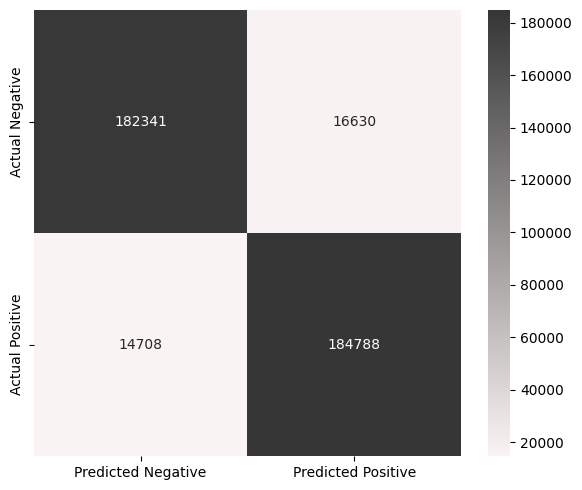

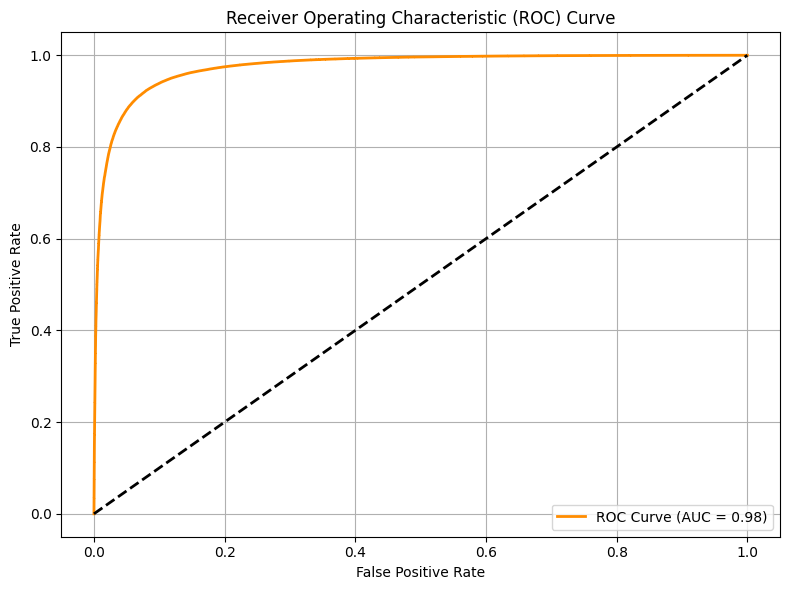

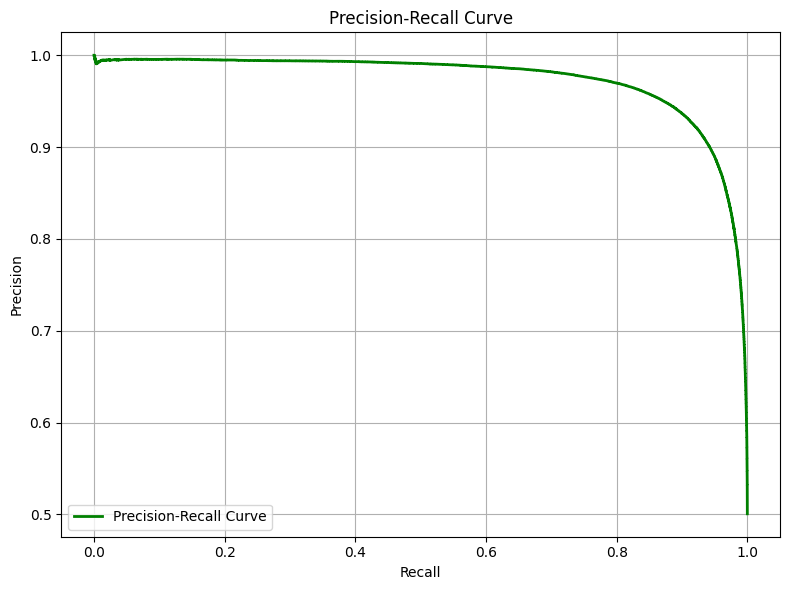

The classifier does not have a 'coef_' attribute. Skipping feature importance plot.

Evaluation completed.


In [ ]:
from model_evaluator import evaluate_model

# Load the test data
test_path = f"{path}/test.csv"
raw_test_data = pd.read_csv(test_path, header=None, names=['polarity', 'title', 'text'])

# Clean and preprocess the test data using the same steps as the training data
df_test = clean_dataset(raw_test_data) 
df_test_preprocessed = preprocessor.transform(df_test)

# Separate features (X_test) and labels (y_test)
X_test = df_test_preprocessed[['processed_title', 'processed_text']]
y_test = df_test_preprocessed['sentiment']

# Evaluate the model on the test set using the evaluate_model function
# This function will print out performance metrics (accuracy, F1-score, confusion matrix, etc.)
evaluate_model(classifier=sentiment_classifier, X=X_test, y=y_test)

### Test Evaluation Results

The metrics printed above summarize how our final, tuned sentiment classifier performs on unseen data. A strong performance here indicates that the model’s improvements during training and validation were not simply overfitting, and that the classifier should generalize well to new Amazon reviews. This final step confirms the value of our end-to-end pipeline, from data cleaning to hyper-parameter tuning and model evaluation.